In [1]:
import pandas as pd

In [2]:
df_democrats = pd.read_csv('reddit_opinion_democrats.csv')
df_republicans = pd.read_csv('reddit_opinion_republican.csv')

df_democrats['party'] = 'Democrat'
df_republicans['party'] = 'Republican'

df = pd.concat([df_democrats, df_republicans], ignore_index=True)

In [3]:
df

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,party
0,lwqcyuz,1,Not the only. But it is a reason.,politics,2024-11-12 11:13:17,1gpex5t,Zealousideal-Olive55,0,1,0,...,3061.0,3062.0,4,NaN,Biden’s internal polling showed Trump winning ...,0.55,4,0,2024-11-12 06:53:55,Democrat
1,lwqcy7d,1,https://preview.redd.it/fnpb09xqeg0e1.jpeg?wid...,neoliberal,2024-11-12 11:13:05,1gpf04s,Trojan_Horse_of_Fate,0,1,0,...,91031.0,94293.0,3,The [discussion thread](https://neoliber.al/dt...,Discussion Thread,0.55,3,0,2024-11-12 07:00:07,Democrat
2,lwqcy5p,1,&gt; I know one of the moderators of r/conspir...,conspiracy,2024-11-12 11:13:04,1gpgvec,Red-Vagabond,0,1,0,...,27645.0,28954.0,88,"Hey peeps, I wanna keep this as short as possi...","I gained 300,000 karma in a half a year on Red...",0.70,88,0,2024-11-12 09:22:38,Democrat
3,lwqcy2q,1,or when they bought Boots skincare and became ...,neoliberal,2024-11-12 11:13:03,1gpf04s,Roseartcrantz,0,1,0,...,198571.0,203707.0,3,The [discussion thread](https://neoliber.al/dt...,Discussion Thread,0.55,3,0,2024-11-12 07:00:07,Democrat
4,lwqcx40,1,"Respectfully. yeah nah, the time for civility ...",politics,2024-11-12 11:12:46,1gp6owu,Vaperius,0,1,0,...,312158.0,361750.0,2640,NaN,AOC denounces anyone engaging in online vitrio...,0.90,2640,0,2024-11-11 23:33:11,Democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7929727,dn4w23l,2,Good bot,ConservativeDemocrat,2017-09-17 18:54:07,70l48o,[deleted],0,2,0,...,0.0,0.0,13,NaN,Trump and Schumer Wrong on Trade,1.00,13,0,2017-09-17 02:44:34,Republican
7929728,dn4guol,3,The top level post has been removed.,ConservativeDemocrat,2017-09-17 13:42:04,70l48o,DuplicatesBot,0,3,0,...,17615.0,17707.0,13,NaN,Trump and Schumer Wrong on Trade,1.00,13,0,2017-09-17 02:44:34,Republican
7929729,dn4ewd5,1,delete,ConservativeDemocrat,2017-09-17 12:43:05,70l48o,Autarch_Severian,0,1,0,...,9094.0,13129.0,13,NaN,Trump and Schumer Wrong on Trade,1.00,13,0,2017-09-17 02:44:34,Republican
7929730,dn4dwix,2,*Third Way had an article*\n\n*on all the time...,ConservativeDemocrat,2017-09-17 12:11:31,70l48o,I_am_a_haiku_bot,0,2,0,...,0.0,0.0,13,NaN,Trump and Schumer Wrong on Trade,1.00,13,0,2017-09-17 02:44:34,Republican


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ericp\AppData\Roaming\nltk_data...


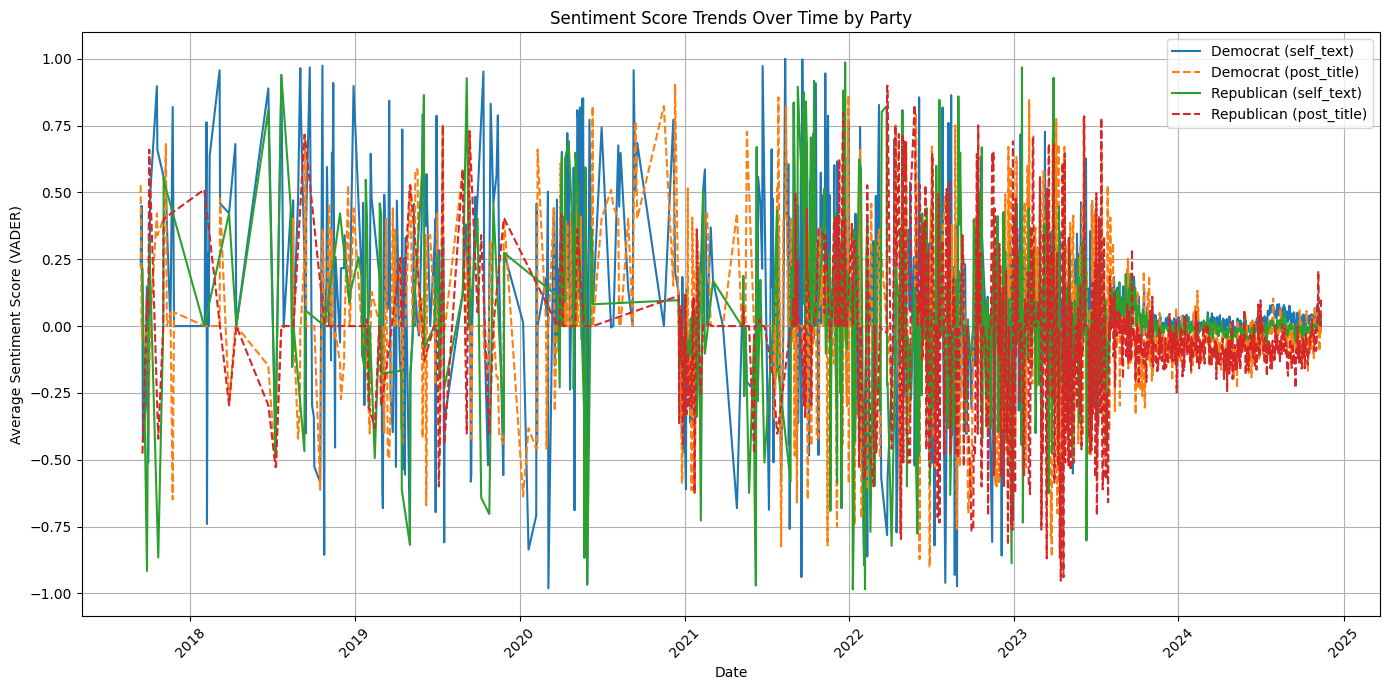

In [4]:
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']  # compound score
    return score

df['sentiment_score_self_text'] = df['self_text'].apply(get_vader_sentiment)
df['sentiment_score_post_title'] = df['post_title'].apply(get_vader_sentiment)

df['created_date'] = pd.to_datetime(df['created_time']).dt.date

sentiment_trend = df.groupby(['created_date', 'party']).agg({
    'sentiment_score_self_text': 'mean',
    'sentiment_score_post_title': 'mean'
}).reset_index()

plt.figure(figsize=(14, 7))
for party in sentiment_trend['party'].unique():
    party_data = sentiment_trend[sentiment_trend['party'] == party]
    plt.plot(party_data['created_date'], party_data['sentiment_score_self_text'], label=f'{party} (self_text)', linestyle='-')
    plt.plot(party_data['created_date'], party_data['sentiment_score_post_title'], label=f'{party} (post_title)', linestyle='--')

plt.title('Sentiment Score Trends Over Time by Party')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score (VADER)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

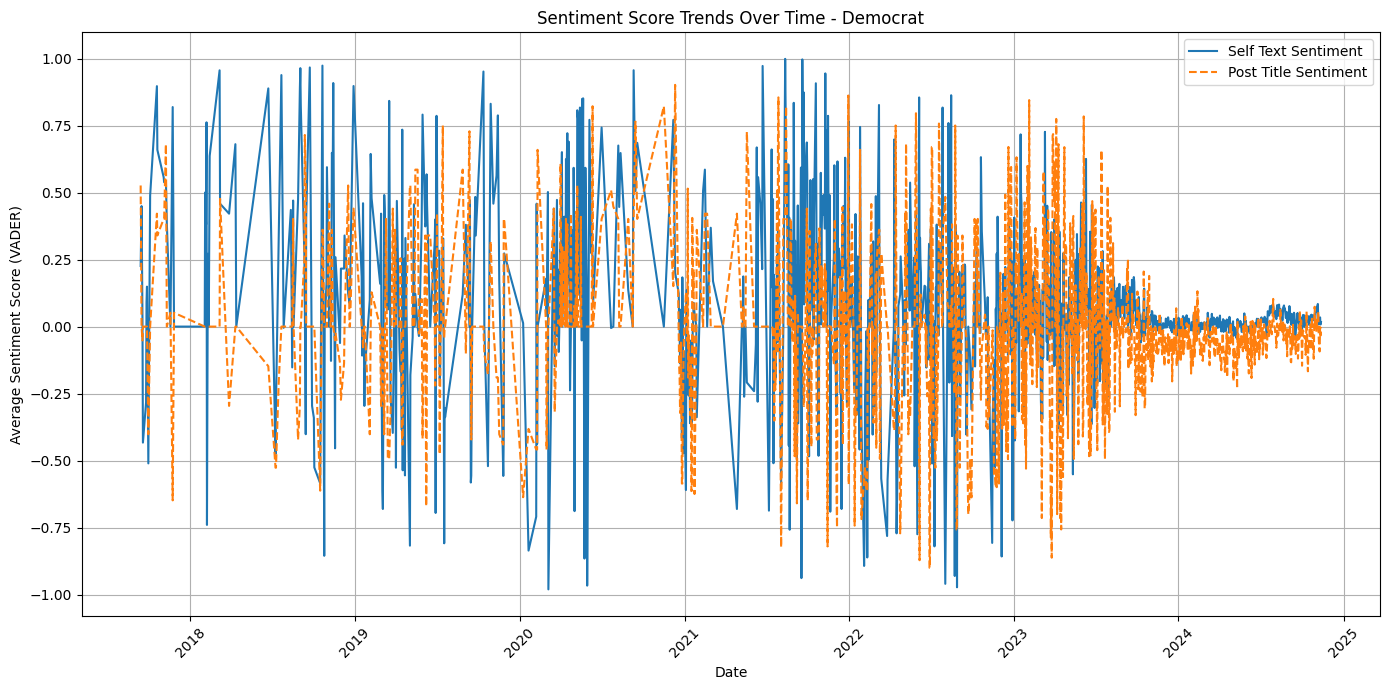

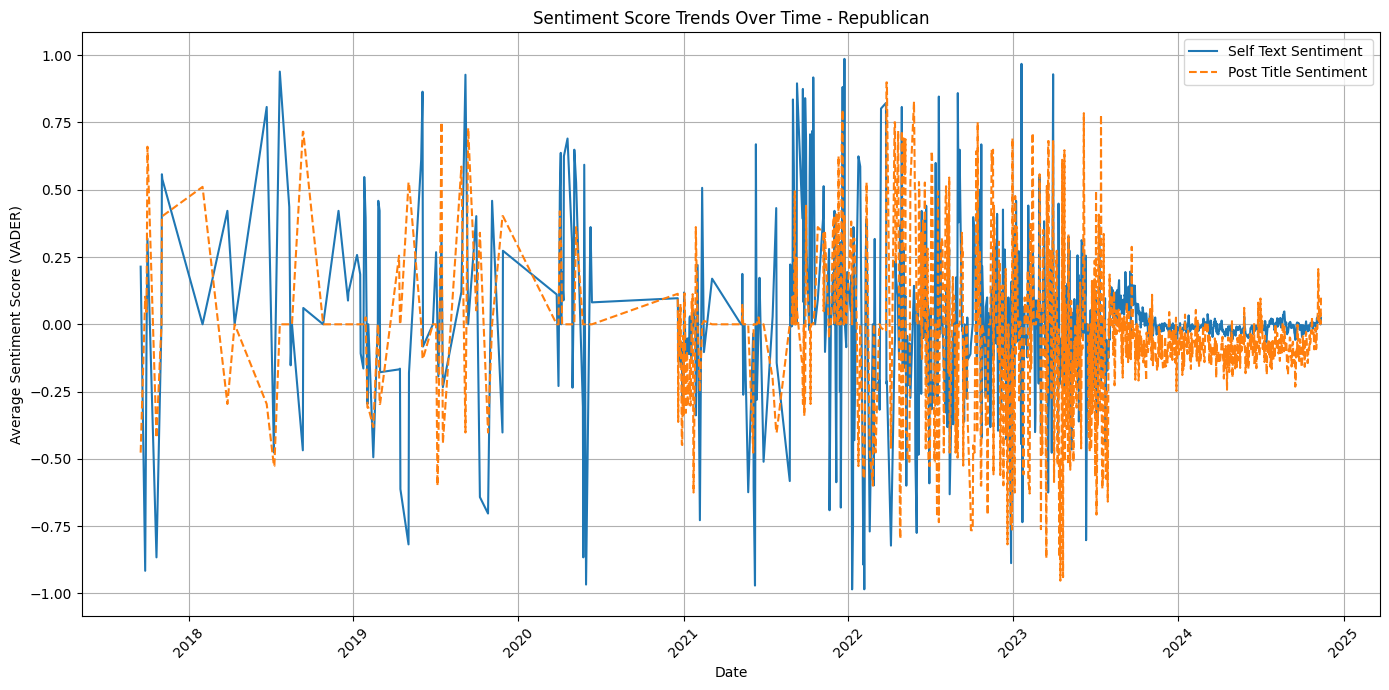

In [5]:
for party in sentiment_trend['party'].unique():

    party_data = sentiment_trend[sentiment_trend['party'] == party]

    plt.figure(figsize=(14, 7))

    plt.plot(party_data['created_date'], party_data['sentiment_score_self_text'], label='Self Text Sentiment', linestyle='-')
    plt.plot(party_data['created_date'], party_data['sentiment_score_post_title'], label='Post Title Sentiment', linestyle='--')
    
    # Customize plot appearance
    plt.title(f'Sentiment Score Trends Over Time - {party}')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score (VADER)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

**Democrat posts generally display more positive sentiment scores over time compared to Republican posts, which show more varied and often more negative sentiment trends, especially in post titles.**